## Εργασία 1: Μηχανική Μάθηση στην Όραση Υπολογιστών

__Παρακαλώ συμπληρώστε τις ακόλουθες πληροφορίες.__
(π.χ. Ιωάννης Κακογεωργίου, 111520XXXXXXXX):

[Όνομα] [Επώνυμο], [Αριθμός μητρώου]

__Σημαντικό__: Aφού κατεβάσετε το αρχείο .ipynb, παρακαλώ ονομάστε το ως <επώνυμο>_<ο_αριθμός_μητρώου_σας>.ipynb πριν το υποβάλετε στην e-class. Παράδειγμα: ΧΧΧΧΧ_ΧΧΧΧΧ.ipynb.

## Μέρος 1.1

## Aπαραίτητες Bιβλιοθήκες

Εκτελέστε τον παρακάτω κώδικα για να φορτωθούν οι απαραίτητες βιβλιοθήκες.
Όταν ολοκληρώσετε την εργασία, θυμηθείτε να εκτελέσετε όλα τα κελιά και να αποθηκεύσετε το notebook στον υπολογιστή σας ως αρχείο .ipynb, ώστε να το υποβάλετε στην e-class

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import platform
import random
from random import randrange
from skimage.color import rgb2gray
from skimage.feature import hog
import time
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import glob
from collections import Counter

random.seed(0)
np.random.seed(0)

# 1. Προετοιμασία Δεδομένων

Σε αυτή την ενότητα θα κατεβάσουμε το σύνολο δεδομένων `imagenette`, θα το αποσυμπιέσουμε και θα κάνουμε κατάλληλα βήματα για να φορτώνουμε τις εικόνες.

Το συγκεκριμένο σύνολο είναι ένα πολύ μικρό υποσύνολο του γνωστού συνόλου [ImageNet](https://www.image-net.org/), το οποίο χρησιμοποιείται για ταξινόμηση εικόνων (image classification).

Αυτό το μικρό σύνολο περιέχει **10 κατηγορίες** : [ fish, English-springer, cassette-player, chain-saw, church, French-horn, garbage-truck, gas-pump, golf-ball, parachute ]  

Συνολικά περιλαμβάνει **9538 εικόνες εκπαίδευσης** και **3856 εικόνες ελέγχου**.

Η δομή του συνόλου δεδομένων είναι η εξής:
```
dataset
  ---train
     ---class1
     ---class2
             .
             .
  ---test
     ---class1
     ---class2
             .
             .
```
Τα δεδομένα έχουν ήδη καθαριστεί και παρακάτω σας παρέχουμε έτοιμες συναρτήσεις φόρτωσης, ώστε να μπορείτε να τα χρησιμοποιήσετε άμεσα.

In [2]:
#!wget "http://users.ntua.gr/gkakogeorgiou/courses/imagenette.zip"

#import requests

#url = "http://users.ntua.gr/gkakogeorgiou/courses/imagenette.zip"  # replace with your actual URL
#response = requests.get(url)

#with open("file.zip", "wb") as f:
#    f.write(response.content)


In [3]:
#!unzip -qq "/content/imagenette.zip"

#import zipfile
#
#with zipfile.ZipFile("file.zip", 'r') as zip_ref:
#    zip_ref.extractall("destination_folder")  # replace with desired folder


In [83]:
train_data_path = './sun/train'
test_data_path = './sun/test'

#train_data_path = './sun_wordmapH/train'
#test_data_path = './sun/wordmapH/test'


train_image_paths = [] #to store image paths in list
test_image_paths = []
classes = [] #to store class values

# get all the paths from train_data_path and append image paths and class to to respective lists

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.replace('\\', '/').split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(sum(train_image_paths,[]))
train_image_paths = [data_path.replace('\\', '/') for data_path in train_image_paths] # If you are working on windows

random.shuffle(train_image_paths)

test_image_paths = list(sum(test_image_paths,[]))
test_image_paths = [data_path.replace('\\', '/') for data_path in test_image_paths] # If you are working on windows

# create a dictionary holding corresponding class names(text) for labels(index)
# this will help when visualizing to print class names
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}



In [84]:
# This class derives from Dataset class in PyTorch
# Transforms are common image transformations (preprocessing steps) available in
#the torchvision.transforms module. They can be chained together using Compose.
class ImageDataset(Dataset):
    def __init__(self, img_paths, img_shape, is_tensor = False):

        self.img_paths = img_paths
        self.img_shape = img_shape

        if is_tensor:
            self.img_transform = transforms.Compose(
                [
                    transforms.Resize((img_shape,img_shape)),
                    transforms.ToTensor()
                ]
            )
        else:
            self.img_transform = transforms.Compose(
                [
                    transforms.Resize((img_shape,img_shape))
                ]
            )

    def __getitem__(self, index):
        # this function loads a single image from its path and returns the image
        # as an array along with its label
        #The __get__item function is called internally by the DataLoader function from torchvision.transforms.

        """
        Returns an example at given index.

        Args:
            index(int): The index of the example to retrieve

        Returns:
            img: The image at the given index
            label: The label associated with the given image
        """
        img_filepath = self.img_paths[index]
        img = Image.open(img_filepath).convert("RGB")
        img = self.img_transform(img)
        img = np.asarray(img,dtype=np.float64)
        label = img_filepath.split('/')[-2]
        label = class_to_idx[label]
        return img, label

    def __len__(self):

        """
        Returns the size of the dataset or number of examples in the dataset
        """

        return len(self.img_paths)

## Λειτουργία Δοκιμής (Debug Flag)
Όταν θέλετε να δοκιμάσετε τον κώδικά σας, ενεργοποιήστε τη λειτουργία δοκιμής θέτοντας τη μεταβλητή `DEBUG` σε `True`.

Αυτό θα περιορίσει το σύνολο εκπαίδευσης στο 20% των δεδομένων, κάνοντας την εκτέλεση πιο γρήγορη και ευέλικτη για έλεγχο και διόρθωση λαθών.

Μόλις ολοκληρώσετε την υλοποίηση σας, μην ξεχάσετε να αλλάξετε τη μεταβλητή `DEBUG` σε `False` και να εκτελέσετε ξανά όλα τα κελιά, ώστε το notebook να είναι έτοιμο προς υποβολή.

In [85]:
DEBUG = True

### ΠΡΟΑΙΡΕΤΙΚΟ
Μπορείτε επίσης να δοκιμάσετε τις υλοποιήσεις σας με μεγαλύτερο μέγεθος εικόνας, τροποποιώντας την παρακάτω μεταβλητή `img_size`.

**ΣΗΜΕΙΩΣΗ**: Το συγκεκριμένο κελί πρέπει να εκτελεστεί τουλάχιστον μία φορά.

In [86]:
img_size = 32

# data_loader with load images as size 32x32
# You can try with img_size = 64 to check if it improves the accuracy

## Φόρτωση και Οπτικοποίηση του συνόλου δεδομένων Tiny ImageNet

### Οπτικοποιήστε μερικά παραδείγματα από το σύνολο δεδομένων.

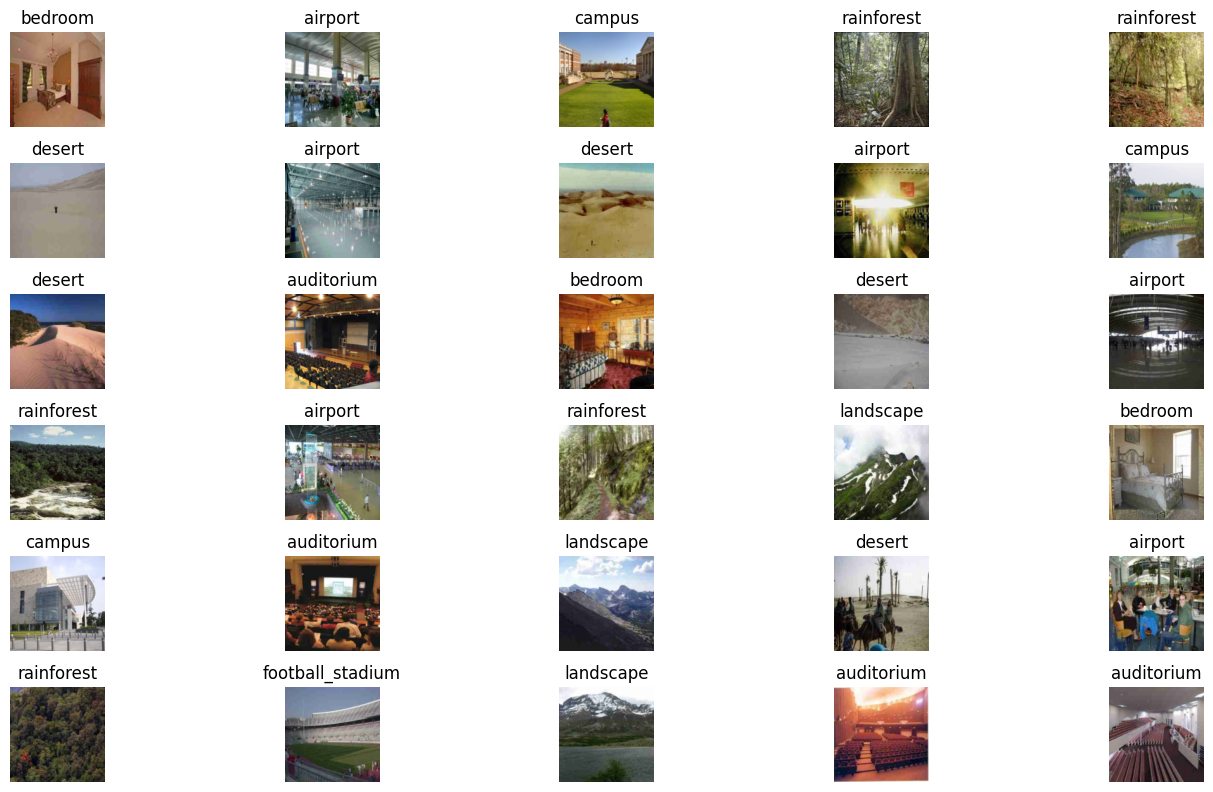

In [87]:
train_dataset = ImageDataset(train_image_paths,img_shape=150,is_tensor=False)

def visualize_data(train_dataset, num_samples):
    figure, ax = plt.subplots(nrows=num_samples//5, ncols=5, figsize=(15, 8))
    for i in range(5*(num_samples//5)):
        image, lab = train_dataset[i]
        ax.ravel()[i].imshow(np.uint8(image))
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_data(train_dataset, 30 )

### Φορτώστε ολόκληρο το σύνολο δεδομένων.

In [88]:
train_dataset = ImageDataset(train_image_paths, img_shape=img_size, is_tensor=False)
test_dataset = ImageDataset(test_image_paths, img_shape=img_size, is_tensor=False)

train_batch_size = train_dataset.__len__()
test_batch_size = test_dataset.__len__()

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=True
)

iterator = iter(train_loader)
for batch_train in train_loader:
    X_train, y_train = batch_train

iterator = iter(test_loader)
for batch_test in test_loader:
    X_test, y_test = batch_test

X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [10]:
# Take a smaller subset of the training set for efficient execution of kNN
# We also create a small validation set

if DEBUG:
    knn_num_train = 1900
    knn_num_val = 100
    knn_num_test =  700
else:
    knn_num_train = 9000
    knn_num_val = 538
    knn_num_test =  3856

# Create a dictionary of data for easy access when testing
knn_data_dict = {}

knn_data_dict['X_train'] = X_train[:knn_num_train].reshape(knn_num_train, -1)
knn_data_dict['y_train'] = y_train[:knn_num_train]

knn_data_dict['X_val'] = X_train[knn_num_train:knn_num_train+knn_num_val].reshape(knn_num_val, -1)
knn_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]

knn_data_dict['X_test'] = X_test[:knn_num_test].reshape(knn_num_test, -1)
knn_data_dict['y_test'] = y_test[:knn_num_test]


print('Train data shape: ', knn_data_dict['X_train'].shape)
print('Train labels shape: ', knn_data_dict['y_train'].shape)
print('Validation data shape: ', knn_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_data_dict['y_val'].shape)
print('Test data shape: ', knn_data_dict['X_test'].shape)
print('Test labels shape: ', knn_data_dict['y_test'].shape)

Train data shape:  (1900, 3072)
Train labels shape:  (1900,)
Validation data shape:  (100, 3072)
Validation labels shape:  (100,)
Test data shape:  (700, 3072)
Test labels shape:  (700,)


## **Εργασία 1.1.1**

### (a) Όρισε τον KNearestNeighbor ταξινομητή

In [11]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.
        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
            consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
            y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
         between training points and testing points.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
         test data, where y[i] is the predicted label for the test point X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)
        
        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the l2 distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
        is the Euclidean distance between the ith test point and the jth training
        point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):

                # ===== your code here! =====

                # TODO:
                # Compute the l2 distance between the ith test image and the jth
                # training image, and store the result in dists[i, j].
                dists[i][j] = np.linalg.norm(X[i]-self.X_train[j])



                # ==== end of code ====
        
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the l2 distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.
        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):

            # ===== your code here! =====

            # TODO:
            # Compute the l2 distance between the ith test point and all training
            # points, and store the result in dists[i, :].

            diff = X[i] - self.X_train
            diff = diff ** 2
            dists[i, :] = np.sqrt(np.sum(diff, axis = 1))



            # ==== end of code ====
        
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the l2 distance between each test point in X and each training point
        in self.X_train using no explicit loops.
        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # ===== your code here! =====

        # TODO:
        # Compute the l2 distance between all test points and all training
        # points without using any explicit loops, and store the result in
        # dists.
        #
        # You should implement this function using only basic array operations;
        # in particular you should not use functions from scipy.
        #
        # HINT: ||x - y||^2 = ||x||^2 + ||y||^2 - 2x y^T


        # Assuming you already computed the squared norms:



      
        y = np.sum(self.X_train ** 2, axis = 1, keepdims = True)
      #  print(y.shape)
      
        x = np.sum(X ** 2, axis = 1, keepdims = True)
       # print(x.shape)


        d2 = x + y.T - 2 * np.dot(X, self.X_train.T)
        dists = np.sqrt(d2)


        #dists = x + y.T -2* np.dot(X, self.X_train.T)

        # ==== end of code ====
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.
        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        - knn_idxs: List of arrays, containing Indexes of the k nearest neighbors
          for the test data. So, for num_tests, it will be a list of length
          num_tests with each element of the list, an array of size 'k'. This will
          be used for visualization purposes later.
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        knn_idxs = []
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.

            closest_y = []

            # ===== your code here! =====

            sorted = np.argsort(dists[i,:], axis = 0)[:k]
            closest_y = self.y_train[sorted]
            knn_idxs.append(sorted)

            # TODO:
            # Use the distance matrix to find the k nearest neighbors of the ith
            # testing element, and use self.y_train to find the labels of these
            # neighbors. Store these labels in closest_y.
            # Also, don't forget to apprpriately store indices knn_idxs list.
            # Hint: Look up the function numpy.argsort.


            # ==== end of code ====

            # Now that you have found the labels of the k nearest neighbors, the code
            # below finds the most common label in the list closest_y of labels.
            # and stores this label in y_pred[i]. We break ties by choosing the
            # smaller label.

            vote = Counter(closest_y)
            count = vote.most_common()
            y_pred[i] = count[0][0]

        return y_pred, knn_idxs

### (b) Έλεγχος υλοποίησης L2 μετρικής απόστασης
Τώρα κάντε μερικούς ελέγχους για να εξετάσετε αν έχετε υλοποιήσει σωστά τις συναρτήσεις.

Αρχικά υπολογίστε τις αποστάσεις χρησιμοποιώντας τη συνάρτηση `compute_distance_two_loops` και ελέγξτε την ακρίβεια για τις τιμές k=1 και k=3.

Στη συνέχεια, συγκρίνετε τις συναρτήσεις `compute_distance_one_loop` και `compute_distance_no_loop` με τη `compute_distance_two_loops` για να διαπιστώσετε αν δίνουν συνεπή αποτελέσματα.

Αρχικοποιήστε τον ταξινομητή KNN (K-Nearest Neighbors).

In [12]:
classifier = KNearestNeighbor()
classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])

Υπολογίστε τις αποστάσεις μεταξύ του συνόλου εκπαίδευσης (train) και του συνόλου ελέγχου (test).
Αυτό το βήμα μπορεί να χρειαστεί αρκετό χρόνο για να ολοκληρωθεί, καθώς χρησιμοποιούμε τη συνάρτηση με δύο βρόχους (two loops), η οποία δεν είναι αποδοτική.

**6 έως 8 λεπτά για ολόκληρο το σύνολο δεδομένων | 2 έως 3 λεπτά για το μειωμένο debug σύνολο**

In [13]:
dists_two = classifier.compute_distances_two_loops(knn_data_dict['X_test'])

Πρόβλεψη κατηγοριών και έλεγχος ακρίβειας (accuracy) για k = 1

In [14]:
y_test_pred, k_idxs  = classifier.predict_labels(dists_two, k=1)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 213 / 700 correct => accuracy: 0.304286


Πρόβλεψη κατηγοριών και έλεγχος ακρίβειας (accuracy) για k = 3

In [15]:
y_test_pred, k_idxs = classifier.predict_labels(dists_two, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 203 / 700 correct => accuracy: 0.290000


Τώρα ελέγξτε την υλοποίηση με έναν βρόχο (one loop). 
Αυτή η διαδικασία μπορεί να χρειαστεί επίσης αρκετό χρόνο για να ολοκληρωθεί.
**4 έως 6 λεπτά για το πλήρες σύνολο δεδομένων | 1 έως 2 λεπτά για το σύνολο debug**

**Σημείωση**: Αυτή η συνάρτηση ενδέχεται να είναι ελαφρώς πιο αργή από την υλοποίηση με δύο βρόχους λόγω ιδιαιτεροτήτων της Python, της NumPy και της επεξεργασίας από τον επεξεργαστή (CPU). Αυτό είναι αποδεκτό, αρκεί το τελικό αποτέλεσμα να μην έχει διαφορές από την προηγούμενη υλοποίηση.

In [16]:
# Implement the function compute_distances_one_loop in KNearestNeighbor class
# and run the code below:
dists_one = classifier.compute_distances_one_loop(knn_data_dict['X_test'])

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.

difference = np.linalg.norm(dists_two - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Τώρα ελέγξτε την `compute_distance_no_loop` υλοποίηση. Αυτή θα πρέπει να εκτελεστεί σε λιγότερο από 30 δευτερόλεπτα για το πλήρες σύνολο δεδομένων.

In [17]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_no = classifier.compute_distances_no_loops(knn_data_dict['X_test'])

# check that the dist ance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists_two - dists_no, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


Τώρα συγκρίνετε πόσο γρήγορα εκτελούνται οι διάφορες υλοποιήσεις.

In [18]:
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, knn_data_dict['X_test'])
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, knn_data_dict['X_test'])
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, knn_data_dict['X_test'])
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 6.259937 seconds
One loop version took 21.802886 seconds
No loop version took 0.086590 seconds


### (c) Χρησιμοποιήστε το σύνολο επικύρωσης (validation set) για να επιλέξετε την κατάλληλη τιμή του 'K'.

In [19]:
k_choices = [1, 3, 5, 6, 7, 8, 9, 10, 12, 15, 20, 50, 100]
k_accuracies = np.zeros((len(k_choices), ))
classifier = KNearestNeighbor()
max_accuracy = 0
max_k = 0

classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_data_dict['X_val'])
for ik, k in enumerate(k_choices):

    # ===== your code here! =====

    # TODO:
    # Find the accuracies for all the k values given in k_choices. You need to
    # use the validation set from the dictionary knn_data_dict already defined
    # for prediction and find its k nearest neighbors in the training set.
    # Note: Access the dataset using the knn_data_dict dictionary defined earlier.

    # HINT: See how we had used the KNearestNeighbor() class
    # functions for k=1 and k=5 in the above cells.

    y_test_pred, k_idxs = classifier.predict_labels(dists, k = k)
    num_correct = np.sum(y_test_pred == knn_data_dict['y_val'])
    acc = float(num_correct)/ knn_num_val
    k_accuracies[ik] = acc
    


    # ==== end of code ====

    if(k_accuracies[ik] > max_accuracy):
        max_accuracy = k_accuracies[ik]
        max_k = k
    print("k = %d, accuracy = %f" %(k, k_accuracies[ik]))

print("Maximum validation accuracy obtained is: %f for k = %d" %(max_accuracy,max_k))

k = 1, accuracy = 0.220000
k = 3, accuracy = 0.250000
k = 5, accuracy = 0.220000
k = 6, accuracy = 0.280000
k = 7, accuracy = 0.290000
k = 8, accuracy = 0.250000
k = 9, accuracy = 0.260000
k = 10, accuracy = 0.270000
k = 12, accuracy = 0.250000
k = 15, accuracy = 0.240000
k = 20, accuracy = 0.280000
k = 50, accuracy = 0.180000
k = 100, accuracy = 0.220000
Maximum validation accuracy obtained is: 0.290000 for k = 7


Text(0, 0.5, 'Validation Accuracies')

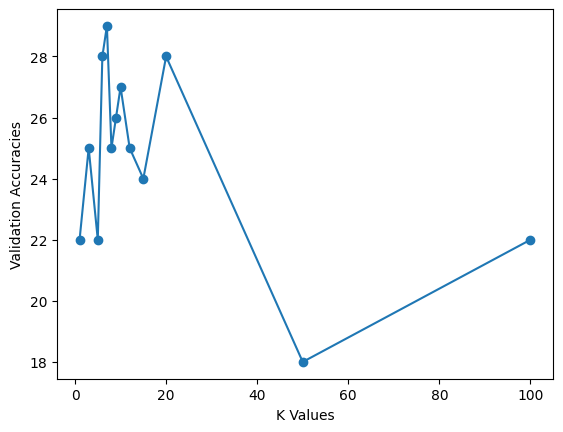

In [20]:
plt.plot(k_choices, 100*k_accuracies, 'o-')
plt.xlabel('K Values')
plt.ylabel('Validation Accuracies')

### **TODO**:
Αναφέρετε την καλύτερη ακρίβεια (accuracy) και την αντίστοιχη τιμή του k στο κελί παρακάτω: 0.38 για k = 15


Χρησιμοποιήστε την καλύτερη τιμή του k που βρήκατε από το σύνολο επικύρωσης (validation set) για να αξιολογήσετε την τελική ακρίβεια σας στο σύνολο ελέγχου (test set).

In [21]:
# Set the value of best_k to be equal to the 'k' which gave the best accuracy
# for the validation set.

best_k = max_k
classifier = KNearestNeighbor()
classifier.train(knn_data_dict['X_train'], knn_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_data_dict['X_test'])
y_test_pred, k_idxs  = classifier.predict_labels(dists, k=best_k)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 214 / 700 correct => accuracy: 0.305714


### Οπτικοποιήστε τα αποτελέσματα του KNN

Ας οπτικοποιήσουμε τις K πλησιέστερες εικόνες για κάποια τυχαία επιλεγμένα παραδείγματα από το σύνολο δοκιμής, χρησιμοποιώντας τη λίστα `k_idxs` που επιστράφηκε από τη συνάρτηση `predict_labels`.

Στην παρακάτω απεικόνιση, η πρώτη στήλη (αριστερά) περιέχει την εικόνα από το σύνολο ελέγχου (test set), ενώ οι υπόλοιπες στήλες δείχνουν τις K πλησιέστερες εικόνες από το σύνολο εκπαίδευσης (train set).

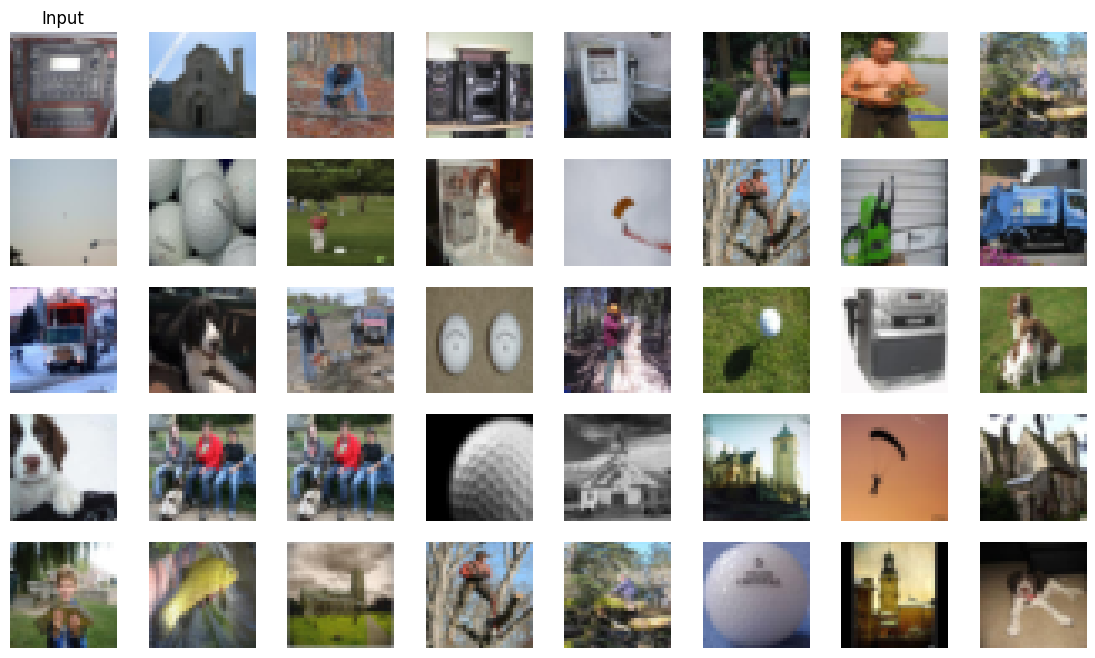

In [22]:
def visualize_knn(num_examples, K):

    idxs = np.random.choice(knn_num_test, num_examples,replace=False)
    vis_im = knn_data_dict['X_test'][idxs]
    _, k_idxs = classifier.predict_labels(dists, k=K)
    vis_labels = np.stack(k_idxs, axis=0)[idxs].astype('uint8')

    num_images = num_examples*K + num_examples

    plt.figure(figsize=(14,8))
    for i in range(num_images):
        plt.subplot(num_examples,K+1,i+1)
        if (i%(K+1) == 0):
            plt.imshow(vis_im[int(i/(K+1))].reshape(img_size,img_size,3).astype('uint8'), interpolation='nearest')
            plt.axis('off')
            if(i==0):
                plt.title('Input')
        else:
            plt.imshow(knn_data_dict['X_train'][vis_labels[int(i/(K+1)), i - (K+1)*int(i/(K+1)) - 1]].reshape(img_size,img_size,3).astype('uint8'))
            plt.axis('off')


# Here the leftmost column is the input image from the test set and rest of the
# K columns are the K nearest neighbors from the training set
num_examples = 5
K = 7
visualize_knn(num_examples, K)

### Η κανονικοποίηση (normalization) των εικόνων οδηγεί σε καλύτερη ακρίβεια;

Εδώ κανονικοποιούμε κάθε εικόνα αφαιρώντας τον μέσο όρο της και διαιρώντας με την τυπική της απόκλιση.

In [23]:
X_instance_mean = np.mean(X_train, axis = (1, 2, 3))
X_instance_std = np.std(X_train, axis = (1, 2, 3))
X_test_instance_mean = np.mean(X_test, axis = (1, 2, 3))
X_test_instance_std = np.std(X_test, axis = (1, 2, 3))
X_train_instance = (X_train - X_instance_mean[:, None, None, None])/X_instance_std[:, None, None, None]
X_test_instance = (X_test - X_test_instance_mean[:, None, None, None])/X_test_instance_std[:, None, None, None]

Αποθηκεύστε τους tensors σε ένα dictionary με όνομα ``` knn_norm_data_dict ```

In [24]:
knn_norm_data_dict = {}

knn_norm_data_dict['X_train'] = X_train_instance[:knn_num_train].reshape(knn_num_train, -1)
knn_norm_data_dict['y_train'] = y_train[:knn_num_train]
knn_norm_data_dict['X_val'] = X_train_instance[knn_num_train:knn_num_train+knn_num_val].reshape(knn_num_val, -1)
knn_norm_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_norm_data_dict['X_test'] = X_test_instance[:knn_num_test].reshape(knn_num_test, -1)
knn_norm_data_dict['y_test'] = y_test[:knn_num_test]

print('Train data shape: ', knn_norm_data_dict['X_train'].shape)
print('Train labels shape: ', knn_norm_data_dict['y_train'].shape)
print('Validation data shape: ', knn_norm_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_norm_data_dict['y_val'].shape)
print('Test data shape: ', knn_norm_data_dict['X_test'].shape)
print('Test labels shape: ', knn_norm_data_dict['y_test'].shape)

Train data shape:  (1900, 3072)
Train labels shape:  (1900,)
Validation data shape:  (100, 3072)
Validation labels shape:  (100,)
Test data shape:  (700, 3072)
Test labels shape:  (700,)


Υπολογίστε ξανά τις ακρίβειες για τις τιμές k = 1 και k = 3 και συγκρίνετε τα αποτελέσματα σε σχέση με εκείνα που είχατε χωρίς καμία προεπεξεργασία στις εικόνες.

In [25]:
classifier = KNearestNeighbor()
classifier.train(knn_norm_data_dict['X_train'], knn_norm_data_dict['y_train'])

In [26]:
dists = classifier.compute_distances_no_loops(knn_norm_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=1)

In [27]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_norm_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 230 / 700 correct => accuracy: 0.328571


In [28]:
y_test_pred, k_labels = classifier.predict_labels(dists, k=3)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_norm_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 232 / 700 correct => accuracy: 0.331429


Παρατηρω οτι ειναι λιγο καλυτερα αλλα οχι τεραστια διαφορα

## (d) KNN με HOG
Στα προηγούμενα βήματα, χρησιμοποιήσατε απευθείας τα εικονοστοιχεία (pixels) των εικόνων ως είσοδο στον αλγόριθμο k-NN για τον υπολογισμό αποστάσεων.

Σε αυτό το μέρος, θα ακολουθήσετε μια διαφορετική προσέγγιση:

Θα υπολογίσετε και χρησιμοποιήσετε τα Histogram of Oriented Gradients (HOG) ως χαρακτηριστικά (features) για κάθε εικόνα.

Στη συνέχεια, θα εφαρμόσετε τον αλγόριθμο k-NN πάνω σε αυτά τα νέα χαρακτηριστικά για να βρείτε τους κοντινότερους γείτονες.

Παρακαλώ διαβάστε τις περιγραφές που ακολουθούν και συμπληρώστε τις συναρτήσεις.

In [29]:
from skimage import color

def compute_angles(image):
    """
    Computes the gradients in both x and y directions.
    Computes the magnitudes of the gradients.
    Computes the angles from the gradients and map to range [0, 180 deg].
    Inputs:
    - image: A numpy array of shape (32, 32) containing one grayscaled image.
    Returns:
    - magnitudes: A numpy array of shape (32, 32) where magnitudes[i, j]
      is the magnitude of the gradient at the (i, j) pixel in the input image.
    - angles: A numpy array of shape (32, 32) where angles[i, j]
      is the angle of the gradient at the (i, j) pixel in the input image.
    """

    # ===== your code here! =====

    if image.ndim == 3:
        image = color.rgb2gray(image)

    gy, gx = np.gradient(image)
    magnitudes = np.sqrt(gy ** 2 + gx ** 2)
    angles = np.arctan2(gy, gx) * (180 / np.pi)
    angles = angles % 180

    # TODO:
    # Compute the gradients along the rows and columns as two arrays.
    # Compute the magnitude as the square root of the sum of the squares of both gradients
    # Compute the angles as the inverse tangent of the gradients along the rows and
    # the gradients along the columns, and map them to the range [0, 180 deg]


    # ==== end of code ====
    return magnitudes, angles

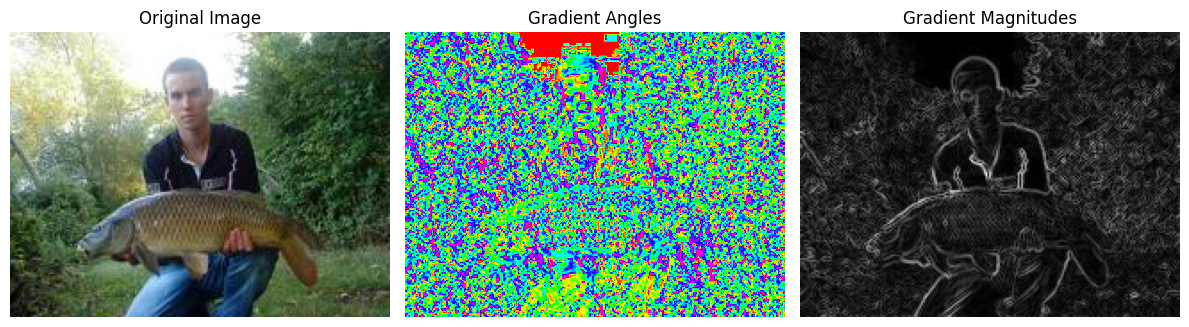

In [30]:
I = plt.imread("./imagenette/train/fish/ILSVRC2012_val_00009379.JPEG")  # Replace this with your actual image

# Compute magnitudes and angles
magnitudes, angles = compute_angles(I)

# Plotting
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(I, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Gradient angles
plt.subplot(1, 3, 2)
plt.imshow(angles, cmap='hsv')  # hsv colormap shows angles well
plt.title("Gradient Angles")
plt.axis('off')

# Gradient magnitudes
plt.subplot(1, 3, 3)
plt.imshow(magnitudes, cmap='gray')
plt.title("Gradient Magnitudes")
plt.axis('off')

plt.tight_layout()
plt.show()

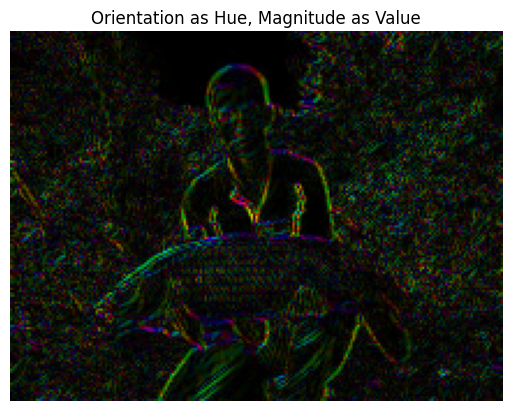

In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_orientation_hsv(angles, magnitudes):
    # Normalize angles to [0,1] for hue
    hue = angles / 180.0
    saturation = np.ones_like(hue)
    value = magnitudes / (np.max(magnitudes) + 1e-5)  # normalize mag

    hsv = np.stack((hue, saturation, value), axis=-1)
    rgb = cv2.cvtColor((hsv * 255).astype(np.uint8), cv2.COLOR_HSV2RGB)

    plt.imshow(rgb)
    plt.title("Orientation as Hue, Magnitude as Value")
    plt.axis('off')
    plt.show()

visualize_orientation_hsv(angles, magnitudes)

In [32]:
def compute_hog(angles, magnitudes, num_bins, pixels_per_cell, cells_per_block):
  """
  Creates a Histogram of Oriented Gradients (HOG) weighted by gradient
  magnitudes from the orientations and magnitudes of an image
  Inputs:
  - angles: A numpy array of shape (32, 32) where angles[i, j]
    is the angle of the gradient at the (i, j) pixel in the input image.
  - magnitudes: A numpy array of shape (32, 32) where magnitudes[i, j]
    is the magnitude of the gradient at the (i, j) pixel in the input image.
  - num_bins: An int of the number of different bins in the histogram
  representing intervals of different orientations
  - pixels_per_cell: An int representing the number of rows/columns of pixels
  present in each cell
  - cells_per_block: An int representing the number of rows/columns of cells
  present in each block
  """

  num_cell_rows = angles.shape[0] // pixels_per_cell
  histogram = np.zeros((num_cell_rows, num_cell_rows, num_bins));
  step_size = 180 // num_bins

  # ===== your code here! =====

  # TODO:
  # Iterate through each pixel in every cell
  # Find the index to the bin in histogram for that pixel's orientation
  # Add the weighted magnitude to the corresponding bins in the histogram
  
  for i in range(num_cell_rows):
    for j in range(num_cell_rows):
        # Define pixel region for this cell
        row_start = i * pixels_per_cell
        row_end = row_start + pixels_per_cell
        col_start = j * pixels_per_cell
        col_end = col_start + pixels_per_cell

        # Extract the angles and magnitudes of this cell
        cell_angles = angles[row_start:row_end, col_start:col_end]
        cell_magnitudes = magnitudes[row_start:row_end, col_start:col_end]

        # Flatten the arrays
        flat_angles = cell_angles.flatten()
        flat_magnitudes = cell_magnitudes.flatten()

        # Compute histogram for this cell
        for k in range(len(flat_angles)):
            bin_idx = int(flat_angles[k] // step_size)
            histogram[i, j, bin_idx] += flat_magnitudes[k]


  # ==== end of code ====

  normalize_histogram(histogram, num_cell_rows, cells_per_block, epsilon=1e-5)
  return histogram.flatten()

**ΣΗΜΕΙΩΣΗ**: Αφού δημιουργήσετε ένα ιστόγραμμα βασισμένο στις κλίσεις (gradients) της εικόνας, είναι απαραίτητο να το κανονικοποιήσετε.

Οι κλίσεις μιας εικόνας είναι ευαίσθητες στις μεταβολές του φωτισμού. Αν, για παράδειγμα, σκουρύνουμε την εικόνα διαιρώντας όλες τις τιμές των pixels με το 2, τότε και το μέγεθος των κλίσεων θα μειωθεί στο μισό — κάτι που σημαίνει ότι και οι τιμές του ιστογράμματος θα μειωθούν στο μισό.

Ιδανικά, θέλουμε τα χαρακτηριστικά (features) των εικόνων μας να είναι ανεξάρτητα από τέτοιες αλλαγές φωτισμού. Με άλλα λόγια, θέλουμε να κανονικοποιήσουμε το ιστόγραμμα ώστε να μην επηρεάζεται από τη φωτεινότητα της εικόνας.

Ο παρακάτω κώδικας που σας παρέχουμε υλοποιεί ακριβώς αυτή την κανονικοποίηση.

In [33]:
def normalize_histogram(histogram, num_cell_rows, cells_per_block, epsilon=1e-5):
    """
    Normalizes the histogram in blocks of size cells_per_block.
    Inputs:
    - histogram: A numpy array of shape (num_cell_rows, num_cell_rows, num_bins)
    representing the histogram of oriented gradients of the input image.
    It can be modified in place.
    - num_cell_rows: An int representing the number of rows/columns of cells
    in the input image.
    - cells_per_block: An int representing the number of rows/coluns of cells that
    should together be normalized in the same block.
    - epsilon: A float indicating the small amount added to the denominator when
    normalizing to avoid dividing by zero.
    """

    num_block_rows = num_cell_rows // cells_per_block
    # Block normalization
    for r in range(num_block_rows):
        for c in range(num_block_rows):
            histogram[r : r + cells_per_block, c : c + cells_per_block, :] /= np.sqrt(np.sum(np.square(histogram[r : r + cells_per_block, c : c + cells_per_block, :])) + epsilon ** 2)

Αφού υλοποιήσετε τις συναρτήσεις HOG, παρακαλείστε να εκτελέσετε τα παρακάτω κελιά για να ελέγξετε τα αποτελέσματα.

Αναμένεται να πετύχετε λίγο καλύτερη ακρίβεια σε σύγκριση με εκείνη που είχατε χρησιμοποιώντας τα (μη κανονικοποιημένα) pixels των εικόνων.

In [34]:
def generate_histogram(image):
    """
    Builds a Histogram of Oriented Gradients (HOG) weighted by gradient magnitudes
    from an input image
    Inputs:
    - image: A numpy array of shape (32, 32) containing one grayscaled image.
    Outputs:
    - histogram: A 1D numpy array of shape
    (num_cell_rows * num_cell_rows * num_bins, ) that shows a HOG of an image.
    """
    # Read and reshape input image
    input_image = image.reshape((img_size, img_size, 3)).astype('uint8')
    grayscaled = rgb2gray(input_image)
    magnitudes, angles = compute_angles(grayscaled)

    # 9 bin, histogram with 64 4x4 pixel cells, normalize 4 cells per block
    # Get histogram of 4 quadrants with 9 bins concatenated into a 8x8x9-dimensional vector

    histogram = compute_hog(angles=angles, magnitudes=magnitudes, num_bins=9, pixels_per_cell=4, cells_per_block=4)

    return histogram

Αυτό το μέρος ενδέχεται να χρειαστεί λίγο χρόνο για να ολοκληρωθεί στο πλήρες σύνολο δεδομένων — περίπου 1 έως 2 λεπτά.

In [35]:
X_train_hog = []
for image_index in range(X_train.shape[0]):
    histogram = generate_histogram(X_train[image_index])
    X_train_hog.append(histogram)

X_test_hog = []
for image_index in range(X_test.shape[0]):
    histogram = generate_histogram(X_test[image_index])
    X_test_hog.append(histogram)

Αποθηκεύστε τους tensors σε ένα dictionary με όνομα ``` knn_hog_data_dict ```

In [36]:
knn_hog_data_dict = {}

knn_hog_data_dict['X_train'] = np.array(X_train_hog[:knn_num_train]).reshape(knn_num_train, -1)
knn_hog_data_dict['y_train'] = y_train[:knn_num_train]
knn_hog_data_dict['X_val'] = np.array(X_train_hog[knn_num_train:knn_num_train+knn_num_val]).reshape(knn_num_val, -1)
knn_hog_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_hog_data_dict['X_test'] = np.array(X_test_hog[:knn_num_test]).reshape(knn_num_test, -1)
knn_hog_data_dict['y_test'] = y_test[:knn_num_test]

print('Train data shape: ', knn_hog_data_dict['X_train'].shape)
print('Train labels shape: ', knn_hog_data_dict['y_train'].shape)
print('Validation data shape: ', knn_hog_data_dict['X_val'].shape)
print('Validation labels shape: ', knn_hog_data_dict['y_val'].shape)
print('Test data shape: ', knn_hog_data_dict['X_test'].shape)
print('Test labels shape: ', knn_hog_data_dict['y_test'].shape)

Train data shape:  (1900, 576)
Train labels shape:  (1900,)
Validation data shape:  (100, 576)
Validation labels shape:  (100,)
Test data shape:  (700, 576)
Test labels shape:  (700,)


In [37]:
classifier = KNearestNeighbor()
classifier.train(knn_hog_data_dict['X_train'], knn_hog_data_dict['y_train'])
dists = classifier.compute_distances_no_loops(knn_hog_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)

In [38]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_hog_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 202 / 700 correct => accuracy: 0.288571


Oπτικοποιήσετε τις K πλησιέστερες εικόνες για ορισμένα τυχαία επιλεγμένα παραδείγματα από το σύνολο ελέγχου (test set), χρησιμοποιώντας τη λίστα `k_idxs` που επιστράφηκε από τη `predict_labels`, η οποία έχει εκπαιδευτεί με βάση τα HOG χαρακτηριστικά (feature).

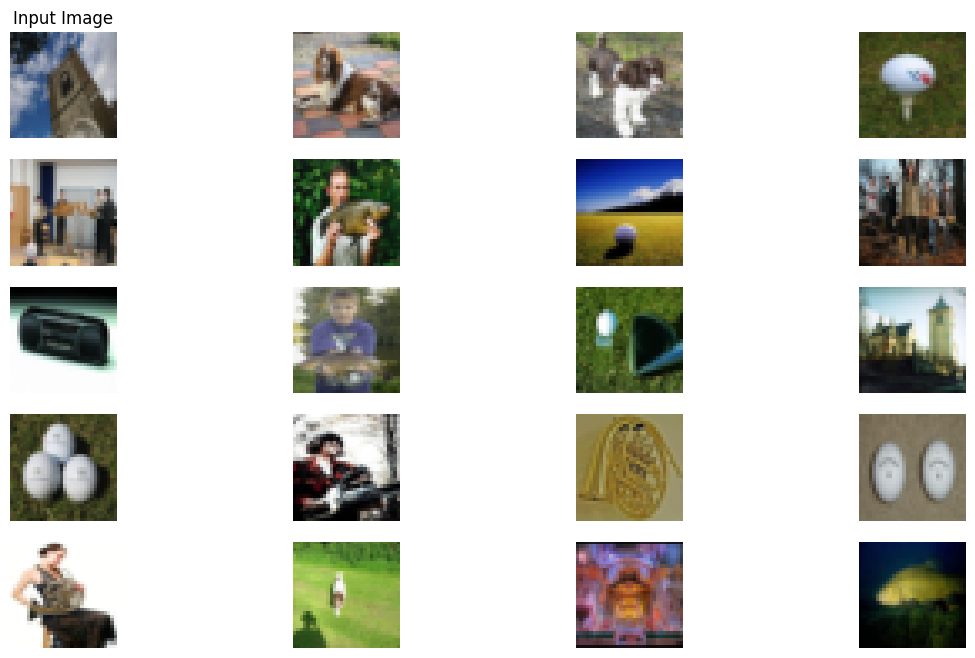

In [39]:
def visualize_knn_sift(num_examples, K):
    idxs = np.random.choice(knn_num_test, num_examples,replace=False)
    vis_im = knn_data_dict['X_test'][idxs]
    vis_labels = np.stack(k_labels, axis=0)[idxs].astype('uint8')

    num_images = num_examples*K + num_examples
    plt.figure(figsize=(14,8))
    for i in range(num_images):
        plt.subplot(num_examples,K+1,i+1)
        if (i%(K+1) == 0):
            plt.imshow(vis_im[int(i/(K+1))].reshape(img_size,img_size,3).astype('uint8'), interpolation='nearest')
            plt.axis('off')
            if(i==0):
                plt.title('Input Image')
        else:
            plt.imshow(knn_data_dict['X_train'][vis_labels[int(i/(K+1)), i - (K+1)*int(i/(K+1)) - 1]].reshape(img_size,img_size,3).astype('uint8'))
            plt.axis('off')

# Here the leftmost column is the input image from the test set and rest of the
# K columns are the K nearest neighbors from the training set
num_examples = 5
K = 3
visualize_knn_sift(num_examples, K)

### (e) Υλοποίηση HOG από τη βιβλιοθήκη scikit-image
Σας παρέχουμε την υλοποίηση του HOG από τη βιβλιοθήκη Scikit-image, η οποία υπολογίζει τα χαρακτηριστικά HOG (HOG features).

Αυτά τα χαρακτηριστικά αναμένεται να προσφέρουν υψηλότερη ακρίβεια σε σχέση με τις απλούστερες υλοποιήσεις.

Μπορείτε να διαβάσετε περισσότερα σχετικά με τη συγκεκριμένη υλοποίηση [εδώ](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_hog.html).

In [40]:
X_train_skimage_hog = []
for image_index in range(X_train.shape[0]):
    histogram = hog(X_train[image_index], pixels_per_cell=(4, 4), cells_per_block=(4, 4), channel_axis=-1)
    X_train_skimage_hog.append(histogram)

X_test_skimage_hog = []
for image_index in range(X_test.shape[0]):
    histogram = hog(X_test[image_index], pixels_per_cell=(4, 4), cells_per_block=(4, 4), channel_axis=-1)
    X_test_skimage_hog.append(histogram)

knn_skimage_hog_data_dict = {}

knn_skimage_hog_data_dict['X_train'] = np.array(X_train_skimage_hog[:knn_num_train]).reshape(knn_num_train, -1)
knn_skimage_hog_data_dict['y_train'] = y_train[:knn_num_train]
knn_skimage_hog_data_dict['X_val'] = np.array(X_train_skimage_hog[knn_num_train:knn_num_train+knn_num_val]).reshape(knn_num_val, -1)
knn_skimage_hog_data_dict['y_val'] = y_train[knn_num_train:knn_num_train+knn_num_val]
knn_skimage_hog_data_dict['X_test'] = np.array(X_test_skimage_hog[:knn_num_test]).reshape(knn_num_test, -1)
knn_skimage_hog_data_dict['y_test'] = y_test[:knn_num_test]

In [41]:
classifier = KNearestNeighbor()
classifier.train(knn_skimage_hog_data_dict['X_train'], knn_skimage_hog_data_dict['y_train'])

dists = classifier.compute_distances_no_loops(knn_skimage_hog_data_dict['X_test'])
y_test_pred, k_labels  = classifier.predict_labels(dists, k=3)

In [42]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == knn_skimage_hog_data_dict['y_test'])
accuracy = float(num_correct) / knn_num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, knn_num_test, accuracy))

Got 228 / 700 correct => accuracy: 0.325714


## **Εργασία 1.1.2**
Γραμμικός ταξινομητής (Linear Classifier)

### Προεπεξεργασία εικόνων
Για να χρησιμοποιήσετε ένα γραμμικό ταξινομητή, πρέπει οι εικόνες να μετατραπούν σε μονοδιάστατα διανύσματα.

Σε αυτή τη συνάρτηση:

- Μετατρέψτε τις εικόνες από `[N, 32, 32, 3]` σε `[N, 3072]`.

- Προσθέστε μία στήλη με άσους (1) σε κάθε εικόνα για να υπολογίζεται και το bias. Έτσι, οι διαστάσεις γίνονται `[N, 3073]`.

- Κανονικοποιήστε τα δεδομένα αφαιρώντας τη μέση εικόνα του train set από όλα τα δεδομένα εκπαίδευσης και ελέγχου.

In [43]:
train_dataset = ImageDataset(train_image_paths, img_shape=img_size, is_tensor=False)
test_dataset = ImageDataset(test_image_paths, img_shape=img_size, is_tensor=False)

train_batch_size = train_dataset.__len__()
test_batch_size = test_dataset.__len__()

train_loader = DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=test_batch_size, shuffle=True
)

iterator = iter(train_loader)
# X_train, y_train = iter(train_loader).next()
for batch_train in train_loader:
    X_train, y_train = batch_train

iterator = iter(test_loader)
# X_test, y_test = iter(test_loader).next()
for batch_test in test_loader:
    X_test, y_test = batch_test

X_train = X_train.numpy()
y_train = y_train.numpy()
X_test = X_test.numpy()
y_test = y_test.numpy()

In [44]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9538, 32, 32, 3)
(9538,)
(3856, 32, 32, 3)
(3856,)


In [45]:
numclasses = np.max(y_test) + 1
print(numclasses)

10


In [46]:
if DEBUG:
    num_training=1900
    num_validation=100
    num_test=3925
else:
    num_training=9000
    num_validation=538
    num_test=3856

# Flatten the images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data: subtract the mean image from train and test data
mean_image = np.mean(X_train, axis=0, keepdims=True)
X_train -= mean_image
X_test -= mean_image

# Append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
ones_train = np.ones((X_train.shape[0],1))
X_train = np.concatenate((X_train, ones_train), axis=1)
ones_test = np.ones((X_test.shape[0],1))
X_test = np.concatenate((X_test, ones_test), axis=1)

# Store them in a dictionary.
data_dict={}
data_dict['X_train'] = X_train[0:num_training]
data_dict['y_train'] = y_train[0:num_training]
data_dict['X_val'] = X_train[num_training:num_training+num_validation]
data_dict['y_val'] = y_train[num_training:num_training+num_validation]
data_dict['X_test'] = X_test[0:num_test]
data_dict['y_test'] = y_test[0:num_test]

print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

Train data shape:  (1900, 3073)
Train labels shape:  (1900,)
Validation data shape:  (100, 3073)
Validation labels shape:  (100,)
Test data shape:  (3856, 3073)
Test labels shape:  (3856,)


### (a) Softmax_loss_naive συνάρτηση

In [47]:
def softmax_loss_naive(W, X, y):
    """
    Softmax loss function, naive implementation (with loops)
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
    Returns a tuple of:
    - loss: loss as single float
    - dW: gradient with respect to weights W averaged across the whole batch;
     an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    num_classes = W.shape[1]
    num_train = X.shape[0]

    # ===== your code here! =====

    # TODO:
    # Loop over each example in the batch
    # Calculate the scores
    # Compute the softmax loss
    # Compute gradient dW using explicit loop
    # Average loss and gradient across the whole batch
    # Note: When calculating dW, subtract the maximum score from each scores to
    # avoid infinity (See note in pdf).
    
    loss = 0.0
    for i, xi in enumerate(X):
        s = np.dot(W.T, xi)
        maxs = np.max(s)
        s -= maxs
        exps = np.exp(s)
        probs = exps/np.sum(exps)

        loss -= np.log(probs[y[i]])

        for j in range(num_classes):
            if j == y[i]:
                dW[:, j] += (probs[j] - 1) * xi
            else:
                dW[:, j] += probs[j] * xi
        

    
    loss /= num_train
    dW /= num_train

    # ==== end of code ====

    return loss, dW

Ως έλεγχος ορθότητας (sanity check) για να βεβαιώσετε ότι η υλοποίηση της συνάρτησης απώλειας (loss) είναι σωστή, τρέξτε τον softmax ταξινομητή με έναν μικρό τυχαίο πίνακα βαρών.

**Αν η υλοποίησή σας είναι σωστή, η τιμή της απώλειας θα πρέπει να είναι κοντά στο -ln(1/10) = 2.3**

In [48]:
# Generate a random weight matrix of small numbers and use it to compute the loss
random.seed(0)
np.random.seed(0)
W = np.random.randn((img_size*img_size*3)+1, 10) * 0.00001

# For debugging purpose we can calculate the loss with very low W and no regularization
# The result should be near log(10) (log(#number_class))

loss, grad = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])
print('loss: %f' % (loss))
print('sanity check: %f' % (np.log(10.0)))

loss: 2.298431
sanity check: 2.302585


Στη συνέχεια, υλοποιούμε για εσάς μια vectorized έκδοση της συνάρτησης απώλειας softmax, ώστε η εκτέλεση να είναι σημαντικά πιο γρήγορη.

Στα επόμενα κελιά θα δείτε και ποσοτικά τη διαφορά στην ταχύτητα.

Αν θέλετε να εξοικειωθείτε με το πώς γράφεται βελτιστοποιημένος κώδικας — κάτι που είναι πολύ χρήσιμο τόσο για τα μοντέλα βαθιάς μάθησης — αξίζει να μελετήσετε αυτή τη συνάρτηση.

In [49]:
def softmax_loss_vectorized(W, X, y):
    """
    Softmax loss function, vectorized version.
    Inputs and outputs are the same as softmax_loss_naive.
    """

    dW = np.zeros(W.shape) # initialize the gradient as zero
    loss = 0.0             # initialize the loss as zero

    num_train = X.shape[0]
    scores = X.dot(W)
    scores -= np.max(scores, axis =1, keepdims = True)
    exp_scores = np.exp(scores)
    scores_exp_sum = np.sum(exp_scores, axis=1, keepdims=True)
    norm_scores = exp_scores/(scores_exp_sum + 1e-12)
    loss = np.sum(-np.log(norm_scores[range(num_train),y]))

    norm_scores[np.arange(num_train),y] -= 1
    dW = np.matmul(X.T, norm_scores)

    loss/=num_train
    dW/=num_train

    return loss,dW

In [50]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# we have provided a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, data_dict['X_val'], data_dict['y_val'])
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, data_dict['X_val'], data_dict['y_val'])
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vectorized, ms_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Speedup: %f' %(ms_naive/ms_vec))

naive loss: 2.298431e+00 computed in 22.691011s
vectorized loss: 2.298431e+00 computed in 1.985312s
Loss difference: 0.000000
Gradient difference: 0.000000
Speedup: 11.429446


### (b) Define Linear Classifier class

In [51]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y,  X_val, y_val, learning_rate=1e-3, num_iters=100, batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Outputs:
        A list containing the value of the loss function at each training iteration.
        """

        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.000001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # ==== your code here ! ====

            # TODO:
            # Sample batch_size elements from the training data and their
            # corresponding labels to use them as arguments for the loss
            # function. Store the data in X_batch and their corresponding labels
            # in y_batch.


            # Hint: Use np.random.choice to generate indices. Sampling with
            # replacement is faster than sampling without replacement.

            batches = np.random.choice(X.shape[0], batch_size, replace = True)
            X_batch = X[batches]
            y_batch = y[batches]      

            # ===== end of code =====

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch)
            loss_history.append(loss)

            # perform parameter update

            # ==== your code here ! ====
            
            self.W -= learning_rate * grad
            
            

            # TODO:
            # Update the weights using the gradient and the learning rate.


            # ===== end of code =====

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            y_val_pred = self.predict(X_val)
            val_accuracy = np.mean(y_val == y_val_pred)

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        # ==== your code here ! ====
        
        scores = np.dot(X, self.W)
        y_pred = np.argmax(scores, axis = 1)

        # TODO:
        # Calculate the scores and store the predicted labels in y_pred.


        # ===== end of code =====
        return y_pred

    def loss(self, X_batch, y_batch):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass

class LinearSoftmax(LinearClassifier):
    """ A subclass that uses the Multiclass loss function """

    def loss(self, X_batch, y_batch):
        return softmax_loss_vectorized(self.W, X_batch, y_batch)

### (d) Εκπαίδευση και έλεγχος του ταξινομητή
Εκτελέστε τον γραμμικό ταξινομητή και παρατηρήστε την ακρίβεια στο σύνολο εκπαίδευσης (train), επικύρωσης (validation) και ελέγχου (test), καθώς και την οπτικοποίηση των βαρών.

Η τιμή της απώλειας (loss) θα πρέπει να ξεκινά περίπου από 2.300 και να μειώνεται σταδιακά μέσα από τις επαναλήψεις, καταλήγοντας σε τελική τιμή μεταξύ 1.800 και 1.600.

In [52]:
softmax = LinearSoftmax()
tic = time.time()
loss_hist = softmax.train(data_dict['X_train'], data_dict['y_train'], learning_rate=1e-7,
                      num_iters=1500, verbose=True, X_val=data_dict['X_val'], y_val=data_dict['y_val'])
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.302983
iteration 100 / 1500: loss 1.936850
iteration 200 / 1500: loss 1.816425
iteration 300 / 1500: loss 1.898293
iteration 400 / 1500: loss 1.820939
iteration 500 / 1500: loss 1.804480
iteration 600 / 1500: loss 1.712603
iteration 700 / 1500: loss 1.704949
iteration 800 / 1500: loss 1.704429
iteration 900 / 1500: loss 1.703953
iteration 1000 / 1500: loss 1.737969
iteration 1100 / 1500: loss 1.634341
iteration 1200 / 1500: loss 1.679651
iteration 1300 / 1500: loss 1.623470
iteration 1400 / 1500: loss 1.681643
That took 4.961700s


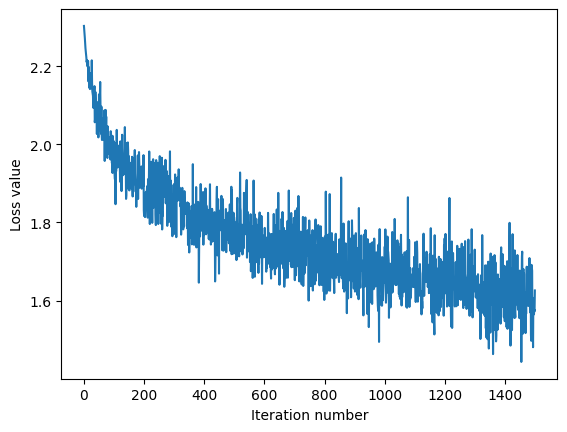

In [53]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [54]:
# Write the LinearSoftmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(data_dict['X_train'])
print('training accuracy: %f' % (np.mean(data_dict['y_train'] == y_train_pred), ))
y_val_pred = softmax.predict(data_dict['X_val'])
print('validation accuracy: %f' % (np.mean(data_dict['y_val'] == y_val_pred), ))

training accuracy: 0.475789
validation accuracy: 0.320000


In [55]:
# Evaluate the best softmax on test set
y_test_pred = softmax.predict(data_dict['X_test'])
test_accuracy = np.mean(data_dict['y_test'] == y_test_pred)
print('Linear Softmax on raw pixels final test set accuracy: %f' % test_accuracy)

Linear Softmax on raw pixels final test set accuracy: 0.371110


Οπτικοποιήστε τα βάρη που έμαθε το μοντέλο για κάθε κατηγορία. Μπορεί να παρατηρήσετε ορισμένα χαρακτηριστικά που ξεχωρίζουν κάθε κατηγορία μέσα από αυτά τα βάρη.

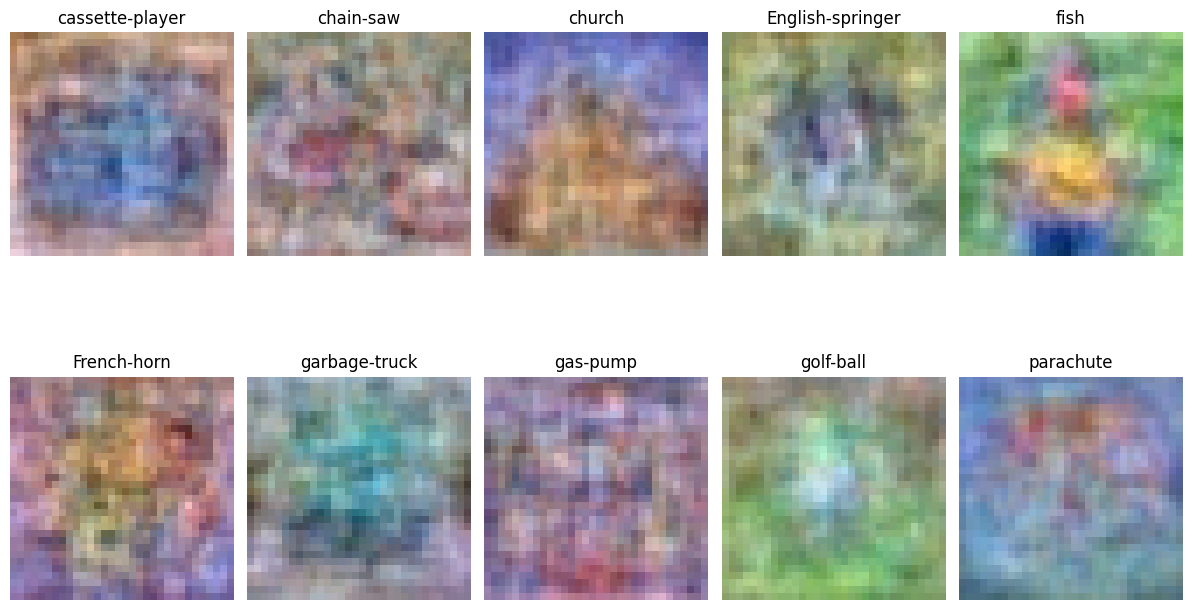

In [56]:
w = softmax.W[:-1,:] # strip out the bias
w = w.reshape(img_size, img_size, 3, 10)
w_min, w_max = np.min(w), np.max(w)

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
for i in range(10):
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    ax.ravel()[i].imshow(wimg.astype('uint8'))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(idx_to_class[i])
plt.tight_layout(pad=1)
plt.show()

## Οπτικοποιήστε τη μέση εικόνα για κάθε κατηγορία.

Εδώ οπτικοποιούμε μια μέση εικόνα για κάθε κατηγορία προσθέτοντας μερικές εικόνες της κατηγορίας και υπολογίζοντας τον μέσο όρο των τιμών των pixels.

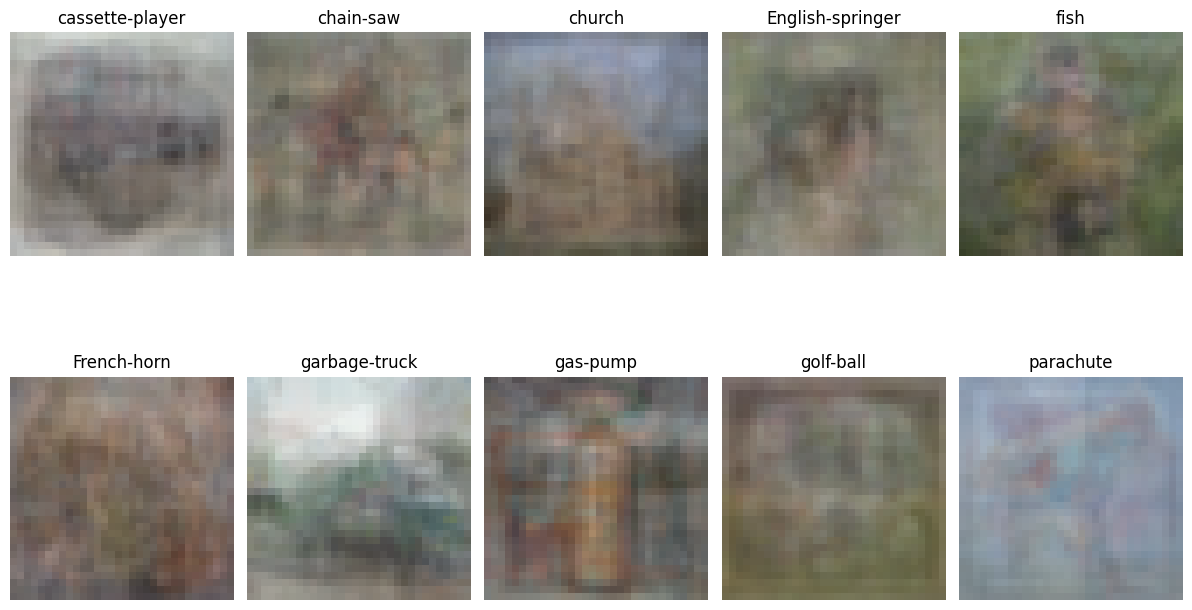

In [57]:
samples_per_class = 20
train_dataset = ImageDataset(train_image_paths, img_shape=img_size, is_tensor=False)

train_loader = DataLoader(
    train_dataset, batch_size=samples_per_class*10, shuffle=True
)

iterator = iter(train_loader)
# X_train, y_train = iter(train_loader).next()
for batch_train in train_loader:
    X_train, y_train = batch_train


X_train = X_train.numpy()
y_train = y_train.numpy()

figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
for i in range(10):
    idxs = np.flatnonzero(y_train == i)
    mean_img = np.mean(X_train[idxs], axis = 0)
    ax.ravel()[i].imshow(mean_img.reshape(img_size,img_size,3).astype('uint8'))
    ax.ravel()[i].set_axis_off()
    ax.ravel()[i].set_title(idx_to_class[i])
plt.tight_layout(pad=1)
plt.show()

## Μέρος 1.2.

### Aπαραίτητες Bιβλιοθήκες

In [58]:
import math
import pickle
import cv2 as cv
import numpy as np
import multiprocessing
from scipy import signal

**Χρήσιμες συναρτήσεις**

In [59]:
def imfilter(I, h):
    I_f = signal.correlate(I, h, mode='same', method='auto')
    return I_f

def fspecial_gaussian(size, sigma=0.5):
    m = (size-1) / 2
    y, x = np.ogrid[-m:m+1, -m:m+1]
    h = np.exp(-(x*x + y*y) / (2*sigma*sigma))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def fspecial_log(size, std):
    siz = int((size-1)/2)
    x = y = np.linspace(-siz, siz, 2*siz+1)
    x, y = np.meshgrid(x, y)
    arg = -(x**2 + y**2) / (2*std**2)
    h = np.exp(arg)
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    h = h/h.sum() if h.sum() != 0 else h
    h1 = h*(x**2 + y**2 - 2*std**2) / (std**4)
    return h1 - h1.mean()

def chi2dist(X, Y):
    s = X + Y
    d = Y - X
    d = (d ** 2 / (s + 1e-10)).sum() / 2.0
    return d

def create_filterbank():
    # Code to generate reasonable filter bank

    gaussianScales = [1, 2, 4, 8, np.sqrt(2)*8]
    logScales      = [1, 2, 4, 8, np.sqrt(2)*8]
    dxScales       = [1, 2, 4, 8, np.sqrt(2)*8]
    dyScales       = [1, 2, 4, 8, np.sqrt(2)*8]

    filterBank = []

    for scale in gaussianScales:
        filter = fspecial_gaussian(2*np.ceil(scale*2.5)+1, scale)
        filterBank.append(filter)

    for scale in logScales:
        filter = fspecial_log(2*np.ceil(scale*2.5)+1, scale)
        filterBank.append(filter)

    for scale in dxScales:
        filter0 = fspecial_gaussian(2 * np.ceil(scale * 2.5) + 1, scale)
        filter = imfilter(filter0, np.array([[-1, 0, 1]]))
        filterBank.append(filter)

    for scale in dyScales:
        filter0 = fspecial_gaussian(2 * np.ceil(scale * 2.5) + 1, scale)
        filter = imfilter(filter0, np.array([[-1], [0], [1]]))
        filterBank.append(filter)

    return filterBank

def rgb2lab(img_rgb):
    if img_rgb.max() > 1.0:
        img_rgb = img_rgb / 255.0

    R = img_rgb[..., 0]
    G = img_rgb[..., 1]
    B = img_rgb[..., 2]

    M, N = img_rgb.shape[:2]
    RGB = np.stack([R.ravel(), G.ravel(), B.ravel()])

    # RGB to XYZ
    MAT = np.array([[0.412453, 0.357580, 0.180423],
                    [0.212671, 0.715160, 0.072169],
                    [0.019334, 0.119193, 0.950227]])
    XYZ = MAT.dot(RGB)

    X = XYZ[0, :] / 0.950456
    Y = XYZ[1, :]
    Z = XYZ[2, :] / 1.088754

    T = 0.008856
    XT = X > T
    YT = Y > T
    ZT = Z > T

    fX = XT * (X **(1 / 3)) + (1 - XT) * (7.787 * X + 16 / 116)

    # Compute L
    Y3 = Y ** (1 / 3)
    fY = YT * Y3 + (1 - YT) * (7.787 * Y + 16 / 116)
    L = YT * (116 * Y3 - 16.0) + (1 - YT) * (903.3 * Y)

    fZ = ZT * (Z ** (1 / 3)) + (1 - ZT) * (7.787 * Z + 16 / 116)

    # Compute a and b
    a = 500 * (fX - fY)
    b = 200 * (fY - fZ)

    Lab = np.stack([L.reshape([M, N]), a.reshape([M, N]), b.reshape([M, N])], axis=2)
    return Lab

(128, 128, 60)


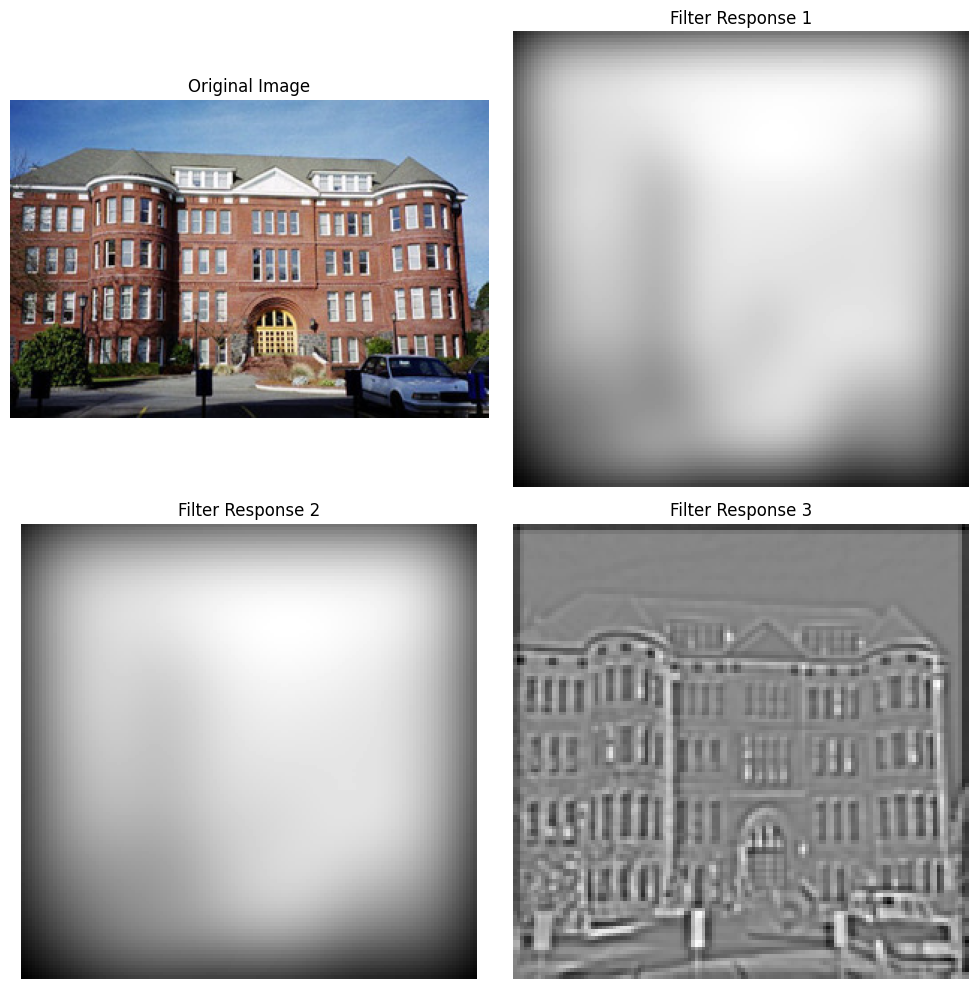

(213, 320, 2, 2)


In [79]:
from skimage.transform import resize
filterBank = create_filterbank()

def extract_filter_responses(I, filterBank):
    H = 128; W = 128
    I = resize(I, (128, 128), anti_aliasing=True)
    Il = rgb2lab(I)
 
    
    n = len(filterBank)
    
    filters = np.zeros((H, W, 3 * n))

    for i, filter in enumerate(filterBank):
        c1 = imfilter(Il[:, :, 0], filter)
        c2 = imfilter(Il[:, :, 1], filter)
        c3 = imfilter(Il[:, :, 2], filter)

        
        filters[:, :, i] = c1
        filters[:, :, i+1] = c2
        filters[:, :, i+2] = c3
        
        
    return filters
        


def get_random_points(I, alpha):
    H, W = I.shape[:2]    
    x = np.random.randint(0, W, size = alpha)
    y = np.random.randint(0, H, size = alpha)
    
    return np.stack((x,y), 1)









def get_gradients(I):

    sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    gradx = cv.filter2D(I, -1, sobelx)
    grady = cv.filter2D(I, -1, sobely)
    return gradx, grady



def covariance_matrix(I, p=3):
    if I.ndim == 3:
        if I.dtype != np.uint8:
            I = (I * 255).astype(np.uint8) if I.max() <= 1.0 else I.astype(np.uint8)
        I = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
    
    I = I.astype(np.float64)
    
    
    grad_x, grad_y = get_gradients(I)
    

    H, W = I.shape
    covariance_matrices = np.zeros((H, W, 2, 2))  
    

    half = p // 2
    for y in range(half, H - half): #No borders
        for x in range(half, W - half):
            region_x = grad_x[y - half:y + half + 1, x - half:x + half + 1]
            region_y = grad_y[y - half:y + half + 1, x - half:x + half + 1]
            
            cov_xx = np.sum(region_x ** 2)
            cov_yy = np.sum(region_y ** 2)
            cov_xy = np.sum(region_x * region_y)
            
            covariance_matrices[y, x] = np.array([[cov_xx, cov_xy], [cov_xy, cov_yy]])


    return covariance_matrices



def harris_points(covariance_matrices, k=0.05):
    H, W, _, _ = covariance_matrices.shape
    R = np.zeros((H, W))

    for y in range(H):
        for x in range(W):
            M = covariance_matrices[y, x]
            R[y, x] = np.linalg.det(M) - k * (np.trace(M) ** 2)

    return R

from scipy.ndimage import maximum_filter
def get_harris_points(I, alpha = 20, k = 0.05):


    cov = covariance_matrix(I, p = 3)
    R = harris_points(cov, k)

  #  R_max = maximum_filter(R, size=3)
   # R[R != R_max] = 0  
    flat_indices = np.argpartition(R.ravel(), -alpha)[-alpha:]
    y_coords, x_coords = np.unravel_index(flat_indices, R.shape)
    return np.stack((x_coords, y_coords), axis=1)
















img = plt.imread('./sun/train/campus/sun_albthhletanyjwjn.jpg')  # Or any RGB image as a NumPy array
filterBank = create_filterbank()
resp = extract_filter_responses(img, filterBank)
print(resp.shape)


import matplotlib.pyplot as plt

# Assuming I is your image and filter_responses contains your filter outputs
# Example: I is a (128, 128, 3) image and filter_responses has filter outputs

I = img
# Display original image and 3 filter responses
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Create a 2x2 grid for 1 original + 3 responses

# Plot the original image
axs[0, 0].imshow(I)  # Display original image
axs[0, 0].set_title("Original Image")
axs[0, 0].axis('off')  # Hide axes

# Plot 3 filter responses (e.g., filter responses at indices 0, 1, 2)
for i in range(3):
    axs[(i+1)//2, (i+1)%2].imshow(resp[:, :, i+3], cmap='gray')  # Display filter response
    axs[(i+1)//2, (i+1)%2].set_title(f"Filter Response {i+1}")
    axs[(i+1)//2, (i+1)%2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

cov_matrices = covariance_matrix(I)
print(cov_matrices.shape)  # Μέγεθος του πίνακα συνδιακύμανσης


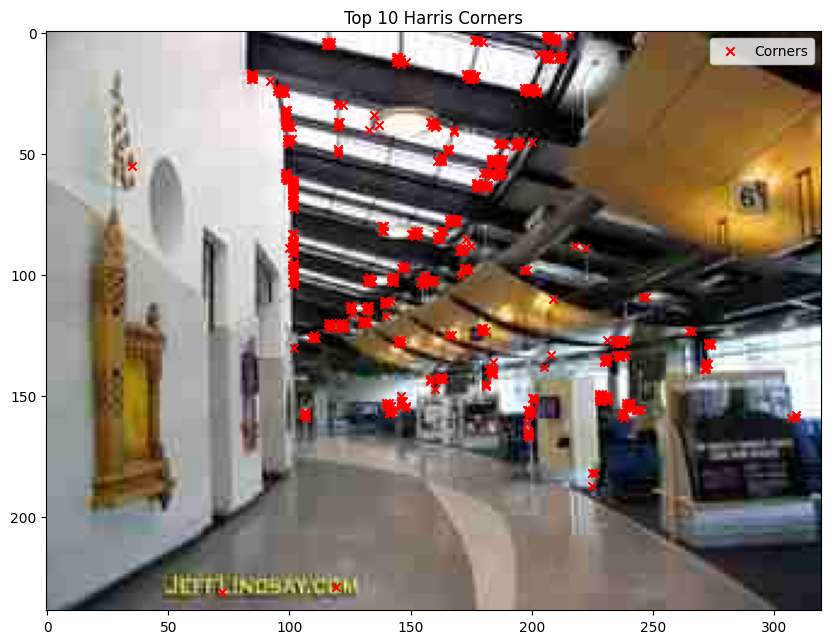

In [76]:
I = plt.imread('./sun/train/airport/sun_aferisdmjeibigjh.jpg')  # Or any RGB image as a NumPy array

alpha = 500

corners = get_harris_points(I, alpha, k = 0.07)

# Visualize the image and corners
plt.figure(figsize=(10, 10))
plt.imshow(I)  # Display the image
plt.scatter(corners[:, 0], corners[:, 1], color='red', marker='x', label='Corners')  # Plot corners
plt.title('Top 10 Harris Corners')
plt.legend()
plt.show()

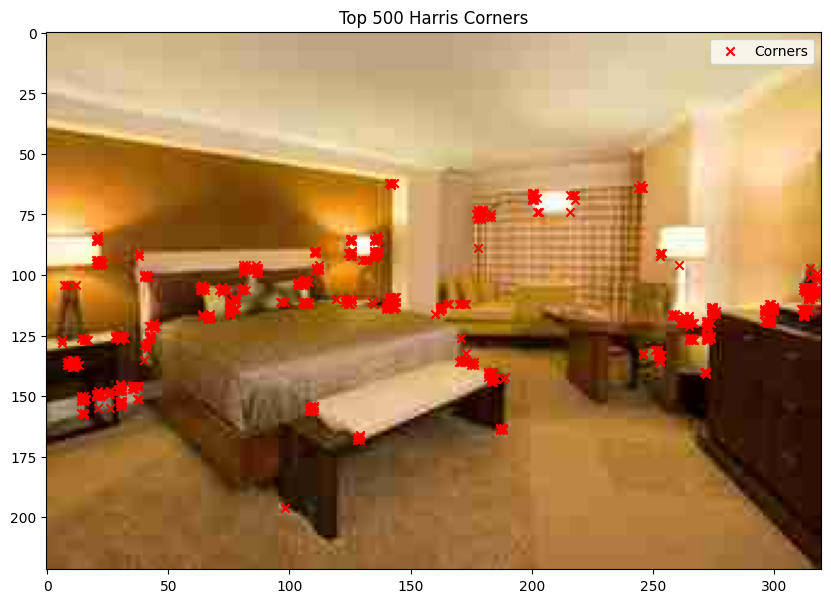

In [75]:
I = plt.imread('./sun/train/bedroom/sun_azmvzkouosdpsahm.jpg')  # Or any RGB image as a NumPy array

alpha = 500

corners = get_harris_points(I, alpha, k = 0.05)

# Visualize the image and corners
plt.figure(figsize=(10, 10))
plt.imshow(I)  # Display the image
plt.scatter(corners[:, 0], corners[:, 1], color='red', marker='x', label='Corners')  # Plot corners
plt.title('Top 500 Harris Corners')
plt.legend()
plt.show()

In [89]:
#1.2.3

from sklearn.cluster import KMeans


def get_dictionary(X_train, alpha, K, method):
    
    num_im = len(X_train)
    dictionary = np.zeros((alpha * num_im, 60))
    j = 0
    for I in X_train:
        if method == "Random":
            points = get_random_points(I, alpha)
        elif method == "Harris":
            points = get_harris_points(I, alpha, k = 0.05)
    
    
        filters = extract_filter_responses(I, filterBank)
     
        for x, y in points:
            dictionary[j] = filters[y, x, :]
            j+=1
        
        
    kmeans = KMeans(n_clusters = K).fit(dictionary)
    
    
    return kmeans
    
    

In [91]:
import pickle
a = 200
K = 500
method = "Random"
res = get_dictionary(X_train, a, K, method)
with open("dictionaryRandom.pkl", "wb") as f:
    pickle.dump(res, f)


method = "Harris"
res2 = get_dictionary(X_train, a, K, method)
with open("dictionaryHarris.pkl", "wb") as f:
    pickle.dump(res2, f)

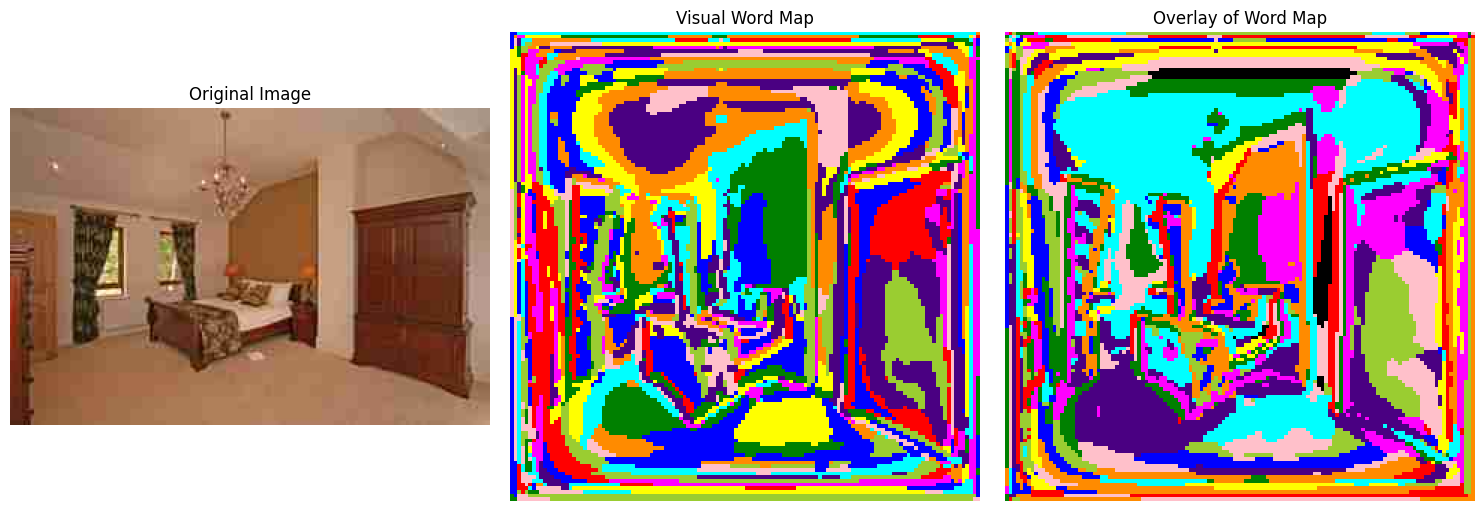

In [92]:
#1.2.4
from sklearn.metrics import pairwise_distances_argmin

def get_visual_words(I, filterBank, dictionary):
    
    features = extract_filter_responses(I, filterBank)
    H, W, F = features.shape
    features = features.reshape(H*W, F)
    
    dists = pairwise_distances_argmin(features, dictionary.cluster_centers_, metric = 'euclidean')
    wordMap = dists.reshape(H, W)
    return wordMap


from skimage.color import label2rgb

I = plt.imread('./sun/train/bedroom/sun_ayfajkzfcyzzbnks.jpg')

with open("dictionaryHarris.pkl", "rb") as f:
    dh = pickle.load(f)

#dh = get_dictionary(X_train, 50, 50, "Harris")
wordMap1 = get_visual_words(I, filterBank, dictionary = dh)

im1 = label2rgb(wordMap1, bg_label=0)

with open("dictionaryRandom.pkl", "rb") as f:
    dr = pickle.load(f)

#dr = get_dictionary(X_train, 50, 50, "Random")
wordMap2 = get_visual_words(I, filterBank, dictionary = dr)

im2 = label2rgb(wordMap2, bg_label=0)


# Display it
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(I)
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(im1)
plt.axis('off')
plt.title("Visual Word Map")

plt.subplot(1, 3, 3)
plt.imshow(im2)
plt.axis('off')
plt.title("Overlay of Word Map")

plt.tight_layout()
plt.show()

    

In [108]:
import os
import numpy as np

from pathlib import Path

import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

def save_all_wordmaps(base_dir, out_dir, filterBank, dictionary):
    subsets = ['train', 'test']
    
    for subset in subsets:
        subset_path = Path(base_dir) / subset
        
        for category in os.listdir(subset_path):
            cat_path = subset_path / category
            if not cat_path.is_dir():
                continue
            
            for filename in os.listdir(cat_path):
                if not filename.endswith(('.jpg', '.png', '.jpeg')):
                    continue

                # Load image
                img_path = cat_path / filename
                I = plt.imread(img_path)
                if I.ndim == 2:
                    I = np.stack([I]*3, axis=2)  # convert grayscale to fake RGB

                if I.dtype != np.uint8:
                    if I.max() <= 1.0:
                        I = (I * 255).astype(np.uint8)
                    else:
                        I = I.astype(np.uint8)

                I = resize(I, (128, 128), anti_aliasing=True)
                
                # Compute wordMap
                wordMap = get_visual_words(I, filterBank, dictionary)

                # Prepare output folder
                out_path = Path(out_dir) / subset / category
                out_path.mkdir(parents=True, exist_ok=True)

                # Save wordMap as .npy
                filename_stem = Path(filename).stem  # removes file extension like .jpg, .png, etc.
                np.save(out_path / (filename_stem + ".npy"), wordMap)


    
        

with open("dictionaryHarris.pkl", "rb") as f:
    dh = pickle.load(f)
with open("dictionaryRandom.pkl", "rb") as f:
    dr = pickle.load(f)
    
save_all_wordmaps("sun", "sun_wordmapR", filterBank, dr)
save_all_wordmaps("sun", "sun_wordmapH", filterBank, dh)
    
        

In [115]:
def load_wordmaps_split(wordmap_dir):
    X_train, X_test = [], []
    y_train, y_test = [], []

    for subset in ['train', 'test']:
        subset_path = Path(wordmap_dir) / subset

        for category in os.listdir(subset_path):
            cat_path = subset_path / category
            if not cat_path.is_dir():
                continue

            for filename in os.listdir(cat_path):
                if filename.endswith('.npy'):
                    wordmap = np.load(cat_path / filename)
                    if subset == 'train':
                        X_train.append(wordmap)
                        y_train.append(category)
                    else:
                        X_test.append(wordmap)
                        y_test.append(category)

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = load_wordmaps_split("sun_wordmapH")


Όμοια με το πρώτο μέρος της εργασίας, τα δεδομένα έχουν ήδη καθαριστεί και μπορείτε να τα χρησιμοποιήσετε άμεσα αξιοποιώντας τις ίδιες συναρτήσεις και διαδικασίες φόρτωσης μέσω των dataloaders που εφαρμόστηκαν στο πρώτο μέρος. Επομένως, για το dataset “sun” ισχύει η ίδια προσέγγιση φόρτωσης.

In [117]:
#1.2.5
def get_image_features(wordMap, dictionarySize):

    h, _ = np.histogram(wordMap, bins=np.arange(dictionarySize + 1))
    return h


def build_features_matrix(wordmaps_list, dictionarySize):
    features = np.zeros((len(wordmaps_list), dictionarySize), dtype=int)
    for i, wm in enumerate(wordmaps_list):
        features[i] = get_image_features(wm, dictionarySize)
    return features


#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

d = dr.n_clusters
trainFeatures = build_features_matrix(X_train, d)
testFeatures = build_features_matrix(X_test, d)

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def run_knn(trainFeatures, trainLabels, testFeatures, testLabels, n_neighbors=5):
    # Create kNN classifier
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Train the classifier
    knn.fit(trainFeatures, trainLabels)
    
    # Predict on test data
    predictions = knn.predict(testFeatures)
    
    # Calculate accuracy
    accuracy = accuracy_score(testLabels, predictions)
    
    print(f"kNN with k={n_neighbors} accuracy: {accuracy:.4f}")
    
    return accuracy, predictions




y_train = np.array(y_train)
y_test = np.array(y_test)

# Optional: print shapes to confirm
print("trainFeatures shape:", trainFeatures.shape)
print("testFeatures shape:", testFeatures.shape)

# Run kNN
accuracy, preds = run_knn(trainFeatures, y_train, testFeatures, y_test, n_neighbors=10)



trainFeatures shape: (1331, 500)
testFeatures shape: (160, 500)
kNN with k=10 accuracy: 0.3312


In [127]:
import os
import numpy as np
from pathlib import Path

def load_wordmaps_split(wordmap_dir):
    X_train, X_test = [], []
    y_train, y_test = [], []
    classes = []

    for subset in ['train', 'test']:
        subset_path = Path(wordmap_dir) / subset

        for category in sorted(os.listdir(subset_path)):
            cat_path = subset_path / category
            if not cat_path.is_dir():
                continue

            if category not in classes:
                classes.append(category)
            label = classes.index(category)

            for filename in os.listdir(cat_path):
                if filename.endswith('.npy'):
                    wordmap = np.load(cat_path / filename)
                    if subset == 'train':
                        X_train.append(wordmap.flatten())
                        y_train.append(label)
                    else:
                        X_test.append(wordmap.flatten())
                        y_test.append(label)

    return (
        np.array(X_train),
        np.array(y_train),
        np.array(X_test),
        np.array(y_test),
        classes  # Optional: for label-to-name mapping
    )

# Example usage
X_train, y_train, X_test, y_test, class_names = load_wordmaps_split("sun_wordmapH")

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)


Train features shape: (1331, 16384)
Test features shape: (160, 16384)
Train labels shape: (1331,)
Test labels shape: (160,)


In [135]:
# Suppose your dictionary size (number of visual words)
dictionary_size = 500  # replace with your actual K

# Reshape each flattened wordMap back to 128x128
X_train_2d = [x.reshape(128, 128) for x in X_train]
X_test_2d = [x.reshape(128, 128) for x in X_test]

# Build histogram features from the 2D wordMaps
trainFeatures = build_features_matrix(X_train_2d, dictionary_size)
testFeatures = build_features_matrix(X_test_2d, dictionary_size)

from sklearn.preprocessing import normalize
trainFeatures_norm = normalize(trainFeatures, norm='l2')
testFeatures_norm = normalize(testFeatures, norm='l2')

#accuracy, _ = run_knn(trainFeatures_norm, y_train, testFeatures_norm, y_test, n_neighbors=5)

# Now run your kNN function
ks = [1, 3, 5, 7, 9, 11, 20, 30, 50, 60, 100, 500]
for k in ks:
    accuracy, _ = run_knn(trainFeatures_norm, y_train, testFeatures_norm, y_test, n_neighbors=k)
    print(f"k={k}, accuracy={accuracy:.4f}")



kNN with k=1 accuracy: 0.3750
k=1, accuracy=0.3750
kNN with k=3 accuracy: 0.3563
k=3, accuracy=0.3563
kNN with k=5 accuracy: 0.3750
k=5, accuracy=0.3750
kNN with k=7 accuracy: 0.3312
k=7, accuracy=0.3312
kNN with k=9 accuracy: 0.3563
k=9, accuracy=0.3563
kNN with k=11 accuracy: 0.3250
k=11, accuracy=0.3250
kNN with k=20 accuracy: 0.3125
k=20, accuracy=0.3125
kNN with k=30 accuracy: 0.3563
k=30, accuracy=0.3563
kNN with k=50 accuracy: 0.3812
k=50, accuracy=0.3812
kNN with k=60 accuracy: 0.3500
k=60, accuracy=0.3500
kNN with k=100 accuracy: 0.3438
k=100, accuracy=0.3438
kNN with k=500 accuracy: 0.3063
k=500, accuracy=0.3063


In [75]:
url = "http://users.ntua.gr/gkakogeorgiou/courses/sun.zip"
response = requests.get(url)

with open("sun.zip", "wb") as f:
    f.write(response.content)

# Μετατροπή του Notebook σε HTML

In [77]:
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!
import os
notebookpath = '' # Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/Assignment_1.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to html {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.html')

ModuleNotFoundError: No module named 'google'